In [1]:
import torch
from torchvision import models, datasets, transforms
from PIL import Image
import time
import copy
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import pickle

In [2]:
train_data_path = "drive/MyDrive/dataset-3-categories/dataset-3-categories-processed/train"
val_data_path = "drive/MyDrive/dataset-3-categories/dataset-3-categories-processed/val"
test_data_path = "drive/MyDrive/dataset-3-categories/dataset-3-categories-processed/test"

In [3]:
num_classes = 3

In [4]:
model = models.vgg11(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:04<00:00, 123MB/s]


In [5]:
for param in model.parameters():
    param.requires_grad = False

In [6]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [9]:
model.classifier[6] = torch.nn.Linear(4096,num_classes)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
print(device)

cuda:0


In [12]:
model = model.to(device)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [7]:
image_size = 256
mean = [0.554, 0.450, 0.343]
std = [0.231, 0.241, 0.241]
batch_size = 64

In [23]:
#from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    accuracy = {"train":[], "val":[]}
    losses = {"train":[],"val":[]}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            losses[phase].append(epoch_loss)
            accuracy[phase].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, accuracy, losses

In [8]:
img_tr = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

In [9]:
aug_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    transforms.RandomErasing()
])

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
data = {
    'train': datasets.ImageFolder(root=train_data_path, transform=aug_transform),
    'valid': datasets.ImageFolder(root=val_data_path, transform=img_tr),
    'test': datasets.ImageFolder(root=test_data_path, transform=img_tr)
}

In [12]:
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['valid'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

In [24]:
model,acc, losses = train_model(model,dataloaders,criterion,optimizer,num_epochs=15)

Epoch 0/14
----------
train Loss: 0.8069 Acc: 0.6500
val Loss: 0.4558 Acc: 0.9553

Epoch 1/14
----------
train Loss: 0.4583 Acc: 0.8836
val Loss: 0.2697 Acc: 0.9691

Epoch 2/14
----------
train Loss: 0.3397 Acc: 0.9077
val Loss: 0.1972 Acc: 0.9691

Epoch 3/14
----------
train Loss: 0.2868 Acc: 0.9221
val Loss: 0.1658 Acc: 0.9691

Epoch 4/14
----------
train Loss: 0.2635 Acc: 0.9293
val Loss: 0.1399 Acc: 0.9691

Epoch 5/14
----------
train Loss: 0.2426 Acc: 0.9293
val Loss: 0.1243 Acc: 0.9691

Epoch 6/14
----------
train Loss: 0.2233 Acc: 0.9302
val Loss: 0.1113 Acc: 0.9725

Epoch 7/14
----------
train Loss: 0.2204 Acc: 0.9361
val Loss: 0.1057 Acc: 0.9725

Epoch 8/14
----------
train Loss: 0.2173 Acc: 0.9272
val Loss: 0.0956 Acc: 0.9725

Epoch 9/14
----------
train Loss: 0.1977 Acc: 0.9391
val Loss: 0.0928 Acc: 0.9725

Epoch 10/14
----------
train Loss: 0.1860 Acc: 0.9420
val Loss: 0.0879 Acc: 0.9725

Epoch 11/14
----------
train Loss: 0.1975 Acc: 0.9391
val Loss: 0.0847 Acc: 0.9691

Ep

In [25]:
torch.save(model.state_dict(), "drive/MyDrive/tl1.pth")

In [27]:
with open('drive/MyDrive/tl1_metrics', 'wb') as f:
    data = {
        'train_acc': acc['train'],
        'val_acc': acc['val'],
        'train_loss': losses['train'],
        'val_loss':losses['val']
    }
    pickle.dump(data, f)

In [13]:
model2 = models.vgg11(pretrained=True)
fc_inputs = model2.classifier[6].in_features
model2.classifier[6] = torch.nn.Sequential(
    torch.nn.Linear(fc_inputs, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(256, 10), 
    torch.nn.LogSoftmax(dim=1)
)
model2.load_state_dict(torch.load("drive/MyDrive/tl1"))
model2.to(device)
model2.eval()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:07<00:00, 72.5MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

train accuracy: 95.56
test accuracy: 96.31
Confusion Matrix:
[[ 92   3   5]
 [  0  38   1]
 [  1   0 131]]


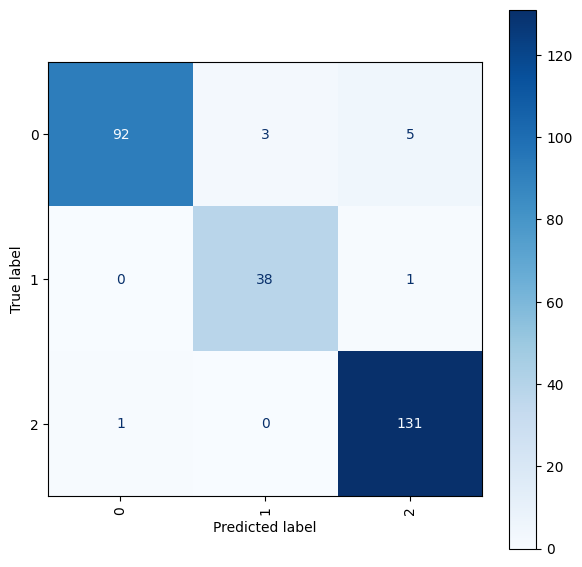

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       100
           1       0.93      0.97      0.95        39
           2       0.96      0.99      0.97       132

    accuracy                           0.96       271
   macro avg       0.96      0.96      0.96       271
weighted avg       0.96      0.96      0.96       271



In [31]:
def evaluate_model(title, model, dataloader, device):
    model.eval()  # for batch normalization layers
    corrects = 0
    y_true = []
    y_pred = []
    if torch.cuda.is_available():
      model.cuda()

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
            y_true.extend(targets.tolist())
            y_pred.extend(preds.tolist())

    print('{title} accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset), title=title))
    if title.lower() == "test":
        # Compute the confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Compute the precision, recall, and F1 score
        report = classification_report(y_true, y_pred)
        print('Confusion Matrix:')
        print(cm)
        fig, ax = plt.subplots(figsize=(7, 7))
        ConfusionMatrixDisplay(cm).plot(ax=ax,cmap='Blues', xticks_rotation='vertical', values_format='d')
        plt.show() 
        print('Classification Report:')
        print(report)

evaluate_model("train", model, dataloaders["train"], device)
evaluate_model("test", model, dataloaders["test"], device)

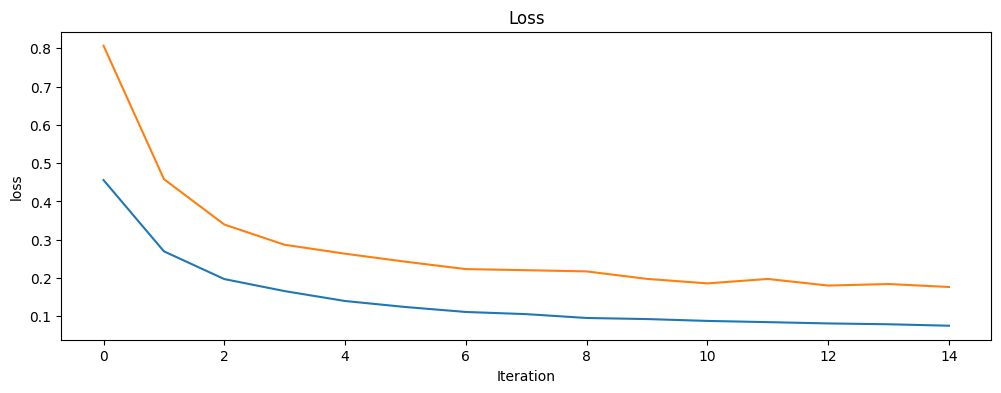

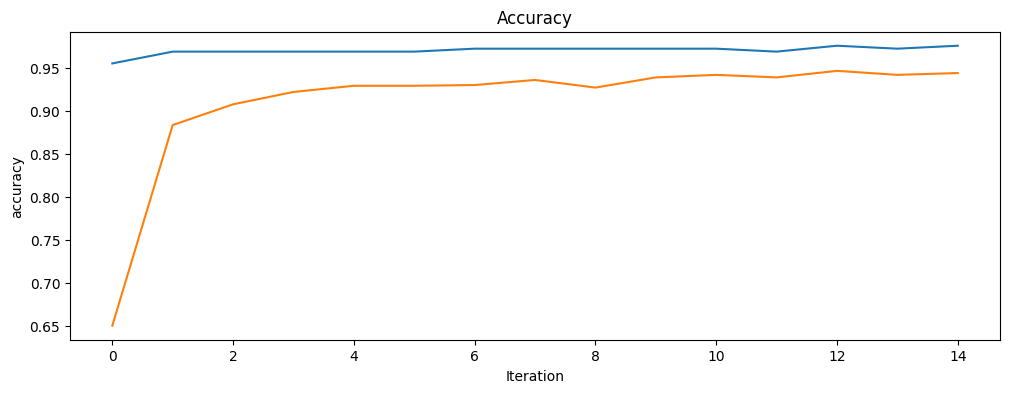

In [32]:
plt.figure(figsize=(12, 4))
plt.plot(losses["val"])
plt.plot(losses["train"])
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Loss')
plt.show()

acc_np = {'train':[],'val':[]}
for el in acc['val']:
  acc_np['val'].append(el.cpu())
for el in acc['train']:
  acc_np['train'].append(el.cpu())

plt.figure(figsize=(12, 4))
plt.plot(acc_np["val"])
plt.plot(acc_np["train"])
plt.xlabel('Iteration')
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.show()


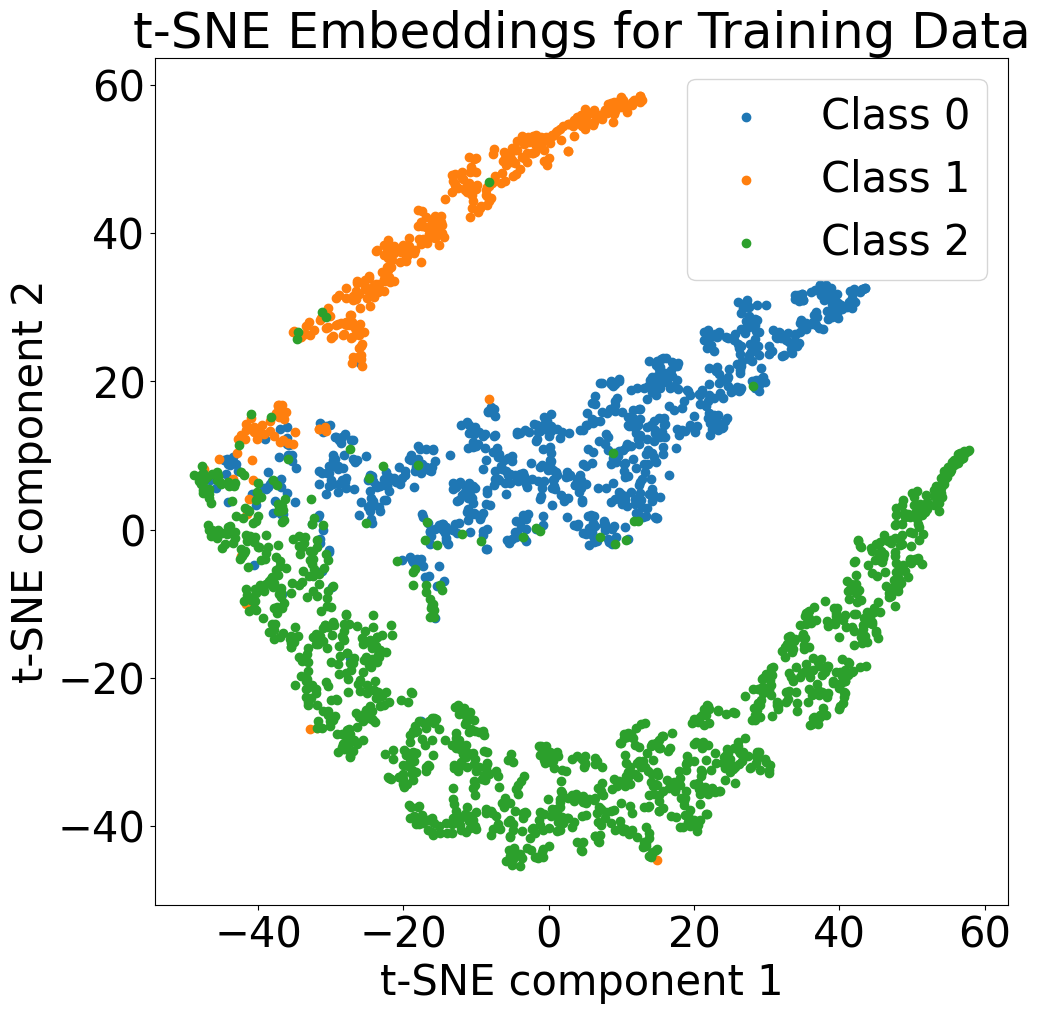

In [14]:
embeddings = []
labels = []
with torch.no_grad():
    for data in dataloaders["train"]:
        images, targets = data[0].to(device), data[1].to(device)
        outputs = model2(images)
        embeddings.append(outputs.cpu().numpy())
        labels.append(targets.cpu().numpy())
embeddings = np.concatenate(embeddings)
labels = np.concatenate(labels)

# Apply t-SNE for visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
embeddings_tsne = tsne.fit_transform(embeddings)

# Plot t-SNE embeddings
plt.figure(figsize=(11,11))
plt.rcParams['font.size'] = 30
for i in range(3):
    plt.scatter(embeddings_tsne[labels==i,0], embeddings_tsne[labels==i,1], label=f'Class {i}')
plt.legend()
plt.title('t-SNE Embeddings for Training Data')
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.show()